# 2. PCA+SVM完成人脸识别任务：使用PCA提取图像的主成分作为输入特征，使用SVM模型进行人脸识别，并尝试使用grid_search来优化调整SVM的参数。


提示：数据集导入使用from sklearn.datasets import fetch_lfw_people




基本上抄写了官方文档的例子：

http://sklearn.apachecn.org/cn/0.19.0/auto_examples/applications/plot_face_recognition.html#sphx-glr-auto-examples-applications-plot-face-recognition-py

+ 从网络上下载人脸检测数据集

In [37]:
from sklearn.datasets import fetch_lfw_people

lfw_people = fetch_lfw_people(min_faces_per_person=70, resize=0.4)

+ 通过 Python 的自省功能，看看 lfw_people 有哪些属性。

In [38]:
type(lfw_people)

sklearn.utils.Bunch

In [39]:
dir(lfw_people)

['DESCR', 'data', 'images', 'target', 'target_names']

In [6]:
lfw_people.data.shape

(1288, 1850)

In [7]:
lfw_people.images.shape

(1288, 50, 37)

+ lfw_people 中，data 是图片数据展平到一个维度的结果，images 就是图像读到内存以后的像素矩阵。

下面看一张图片。

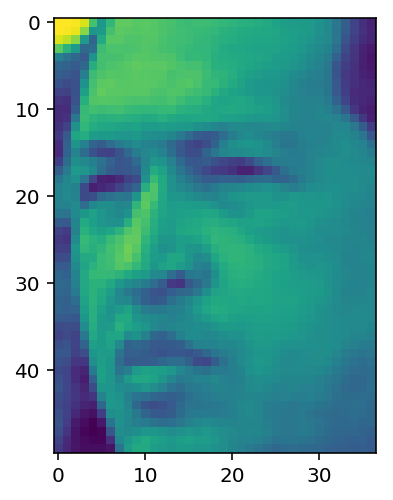

In [40]:
plt.imshow(lfw_people.data[0].reshape(50, 37))

+ 将原始数据分离为训练数据集和测试数据集

In [14]:
X = lfw_people.data
y = lfw_people.target

In [41]:
from sklearn.model_selection import train_test_split


X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42)

In [42]:
lfw_people.data.shape

(1288, 1850)

+ 可以看到特征数量比训练数量还多，我们把每个像素都当做一个特征来对待，数据的噪声就很严重，因此我们要通过降维算法，抽取主要特征，送入分类算法。

In [44]:
from sklearn.decomposition import PCA

# 抽取 150 个特征
n_components = 150

pca = PCA(n_components=n_components, svd_solver='randomized',
          whiten=True)
pca.fit(X_train)

PCA(copy=True, iterated_power='auto', n_components=150, random_state=None,
  svd_solver='randomized', tol=0.0, whiten=True)

In [45]:
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)

In [46]:
sum(pca.explained_variance_ratio_)

0.9567459120880812

+ 可以看到这 150 个特征包括了原始数据 95% 以上的信息。

+ 下面使用网格搜索对 SVM 算法进行调参。

In [26]:
from sklearn.grid_search import GridSearchCV
from sklearn.svm import SVC

param_grid = {'C': [1e3, 5e3, 1e4, 5e4, 1e5],
              'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1], }
clf = GridSearchCV(SVC(kernel='rbf', class_weight='balanced'),
                   param_grid, verbose=2)
clf = clf.fit(X_train_pca, y_train)

Fitting 3 folds for each of 30 candidates, totalling 90 fits
[CV] C=1000.0, gamma=0.0001 ..........................................
[CV] ................................. C=1000.0, gamma=0.0001 -   0.1s
[CV] C=1000.0, gamma=0.0001 ..........................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s


[CV] ................................. C=1000.0, gamma=0.0001 -   0.1s
[CV] C=1000.0, gamma=0.0001 ..........................................
[CV] ................................. C=1000.0, gamma=0.0001 -   0.1s
[CV] C=1000.0, gamma=0.0005 ..........................................
[CV] ................................. C=1000.0, gamma=0.0005 -   0.1s
[CV] C=1000.0, gamma=0.0005 ..........................................
[CV] ................................. C=1000.0, gamma=0.0005 -   0.1s
[CV] C=1000.0, gamma=0.0005 ..........................................
[CV] ................................. C=1000.0, gamma=0.0005 -   0.1s
[CV] C=1000.0, gamma=0.001 ...........................................
[CV] .................................. C=1000.0, gamma=0.001 -   0.1s
[CV] C=1000.0, gamma=0.001 ...........................................
[CV] .................................. C=1000.0, gamma=0.001 -   0.1s
[CV] C=1000.0, gamma=0.001 ...........................................
[CV] .

[CV] ................................. C=50000.0, gamma=0.001 -   0.1s
[CV] C=50000.0, gamma=0.001 ..........................................
[CV] ................................. C=50000.0, gamma=0.001 -   0.1s
[CV] C=50000.0, gamma=0.001 ..........................................
[CV] ................................. C=50000.0, gamma=0.001 -   0.1s
[CV] C=50000.0, gamma=0.005 ..........................................
[CV] ................................. C=50000.0, gamma=0.005 -   0.2s
[CV] C=50000.0, gamma=0.005 ..........................................
[CV] ................................. C=50000.0, gamma=0.005 -   0.2s
[CV] C=50000.0, gamma=0.005 ..........................................
[CV] ................................. C=50000.0, gamma=0.005 -   0.2s
[CV] C=50000.0, gamma=0.01 ...........................................
[CV] .................................. C=50000.0, gamma=0.01 -   0.2s
[CV] C=50000.0, gamma=0.01 ...........................................
[CV] .

[Parallel(n_jobs=1)]: Done  90 out of  90 | elapsed:   14.1s finished


+ 看一下最佳的超参数。

In [27]:
clf.best_params_

{'C': 1000.0, 'gamma': 0.001}

+ 使用网格搜索得到的最优的模型进行预测。

In [32]:
y_pred = clf.best_estimator_.predict(X_test_pca)

+ 多分类问题可以看看精准率、召回率、混淆矩阵

In [35]:
from sklearn.metrics import classification_report

target_names = lfw_people.target_names

print(classification_report(y_test, y_pred, target_names=target_names))

                   precision    recall  f1-score   support

     Ariel Sharon       0.56      0.69      0.62        13
     Colin Powell       0.75      0.88      0.81        60
  Donald Rumsfeld       0.70      0.70      0.70        27
    George W Bush       0.93      0.88      0.91       146
Gerhard Schroeder       0.81      0.84      0.82        25
      Hugo Chavez       0.80      0.53      0.64        15
       Tony Blair       0.85      0.78      0.81        36

      avg / total       0.84      0.83      0.83       322



In [36]:
from sklearn.metrics import confusion_matrix

print(confusion_matrix(y_test, y_pred))

[[  9   0   3   1   0   0   0]
 [  1  53   2   2   0   1   1]
 [  5   1  19   1   0   1   0]
 [  1   9   1 129   3   0   3]
 [  0   2   0   1  21   0   1]
 [  0   3   0   2   2   8   0]
 [  0   3   2   3   0   0  28]]


+ 可以看到：f1-score 是 0.83，混淆矩阵主对角线上的数值很大，其它非主对角线上的元素要么为 0，要么是一个很小的整数，说明我们得到的 SVM 算法是有效的。